# 0. Dependências

In [22]:
# some_file.py
import sys
sys.path.append('../')

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plots
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# 1. Introdução

# 2. Dados 

Os dados de cada tipo de problema (regressão, classificação binária e multiclasse) estão definidos nos testes da implementação.

# 3. Implementação 

###  Funções de ativação

In [24]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# other functions
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

### Funções de Custo 

In [25]:
# cost functions
def mae(y, y_pred, derivative=False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y - y_pred))

def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    return 0.5*np.mean((y - y_pred)**2)

def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1-y_pred) * y.shape[0])
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

### Verificação dos Gradientes

In [26]:
def __compute_approx_grads(nn, x, y, eps=1e-4):
    approx_grads = []
    feed_forward = lambda inp: nn._NeuralNetwork__feedforward(inp)

    for layer in nn.layers:
        w_ori = layer.weights.copy()
        w_ravel = w_ori.ravel()
        w_shape = w_ori.shape

        for i in range(w_ravel.size):
            w_plus = w_ravel.copy()
            w_plus[i] += eps
            layer.weights = w_plus.reshape(w_shape)
            J_plus = nn.cost_func(y, feed_forward(x))

            w_minus = w_ravel.copy()
            w_minus[i] -= eps
            layer.weights = w_minus.reshape(w_shape)
            J_minus = nn.cost_func(y, feed_forward(x))
            approx_grads.append((J_plus - J_minus) / (2.0*eps))
        layer.weights = w_ori

    return approx_grads

def gradient_checking(nn, x, y, eps=1e-4, verbose=False, verbose_precision=5):
    from copy import deepcopy
    nn_copy = deepcopy(nn)

    nn.fit(x, y, epochs=0)
    grads = np.concatenate([layer._dweights.ravel() for layer in nn.layers])

    approx_grads = __compute_approx_grads(nn_copy, x, y, eps)

    is_close = np.allclose(grads, approx_grads)
    print("{}".format("\033[92mGRADIENTS OK" if is_close else "\033[91mGRADIENTS FAIL"))

    norm_num = np.linalg.norm(grads - approx_grads)
    norm_den = np.linalg.norm(grads) + np.linalg.norm(approx_grads)
    error = norm_num / norm_den
    print("Relative error:", error)

    if verbose:
        np.set_printoptions(precision=verbose_precision, linewidth=200, suppress=True)
        print("Gradientes:", grads)
        print("Aproximado:", np.array(approx_grads))

### Rede Neural

In [27]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear):
        self.input = None
        self.weights = np.random.randn(output_dim, input_dim)
        self.biases = np.random.randn(1, output_dim)
        self.activation = activation

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases = None, None

class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        
    def fit(self, x_train, y_train, epochs=100, verbose=10):
        for epoch in range(epochs+1):
            y_pred = self.__feedforward(x_train)
            self.__backprop(y_train, y_pred)
            
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                print("epoch: {0:=4}/{1} loss_train: {2:.8f}".format(epoch, epochs, loss_train))
        
    def predict(self, x):
        return self.__feedforward(x)
    
    def __feedforward(self, x):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)
        
        for layer in reversed(self.layers):
            layer.weights = layer.weights - self.learning_rate*layer._dweights
            layer.biases = layer.biases - self.learning_rate*layer._dbiases

# 4. Teste 

In [28]:
np.random.seed(1234)
N, D = 100, 2
x = np.random.rand(N, D)
y = np.random.rand(N, 1)

## Verificação dos Gradientes

### Regressão

In [29]:
D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y, eps=1e-4, verbose=False)

epoch:    0/100 loss_train: 0.09443909
epoch:   10/100 loss_train: 0.08027429
epoch:   20/100 loss_train: 0.06997904
epoch:   30/100 loss_train: 0.06244557
epoch:   40/100 loss_train: 0.05690320
epoch:   50/100 loss_train: 0.05280786
epoch:   60/100 loss_train: 0.04977095
epoch:   70/100 loss_train: 0.04751232
epoch:   80/100 loss_train: 0.04582842
epoch:   90/100 loss_train: 0.04457045
epoch:  100/100 loss_train: 0.04362907
epoch:    0/0 loss_train: 0.04354904
GRADIENTS OK
Relative error: 9.639099825662846e-08


###  Classificação Binária

In [30]:
y = np.random.randint(0, 2, (N, 1))
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y, eps=1e-4, verbose=False)

epoch:    0/100 loss_train: 0.89516990
epoch:   10/100 loss_train: 0.88638120
epoch:   20/100 loss_train: 0.87791389
epoch:   30/100 loss_train: 0.86975853
epoch:   40/100 loss_train: 0.86190582
epoch:   50/100 loss_train: 0.85434657
epoch:   60/100 loss_train: 0.84707176
epoch:   70/100 loss_train: 0.84007248
epoch:   80/100 loss_train: 0.83334002
epoch:   90/100 loss_train: 0.82686579
epoch:  100/100 loss_train: 0.82064138
epoch:    0/0 loss_train: 0.82003236
GRADIENTS OK
Relative error: 8.641455136912421e-10


### Classificação Multiclasse

In [31]:
y = np.random.randint(0, 2, (N, 1))
y_oh = OneHotEncoder(sparse=False).fit_transform(y)
D_in, D_out = x.shape[1], y_oh.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y_oh, eps=1e-4, verbose=False)

epoch:    0/100 loss_train: 0.12266334
epoch:   10/100 loss_train: 0.12896237
epoch:   20/100 loss_train: 0.13561368
epoch:   30/100 loss_train: 0.14264357
epoch:   40/100 loss_train: 0.15003052
epoch:   50/100 loss_train: 0.15641980
epoch:   60/100 loss_train: 0.16203421
epoch:   70/100 loss_train: 0.16764310
epoch:   80/100 loss_train: 0.17338276
epoch:   90/100 loss_train: 0.17926592
epoch:  100/100 loss_train: 0.18529324
epoch:    0/0 loss_train: 1.09074880
GRADIENTS OK
Relative error: 1.4656979898265753e-09


/home/amp/tools/anaconda3/envs/ds-academy/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Regressão

###  Regressão Linear Simples

In [33]:
data = np.loadtxt('../../data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [34]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 0.9999999999999991


epoch:    0/1000 loss_train: 2252.45947137
epoch:  100/1000 loss_train: 15.74601708
epoch:  200/1000 loss_train: 13.10358581
epoch:  300/1000 loss_train: 13.04288445
epoch:  400/1000 loss_train: 13.04149003
epoch:  500/1000 loss_train: 13.04145799
epoch:  600/1000 loss_train: 13.04145726
epoch:  700/1000 loss_train: 13.04145724
epoch:  800/1000 loss_train: 13.04145724
epoch:  900/1000 loss_train: 13.04145724
epoch: 1000/1000 loss_train: 13.04145724
[[33.60164744]]
[[74.99636286]]


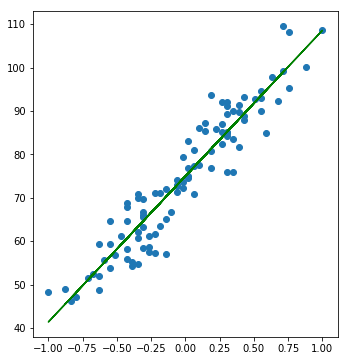

In [35]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada

In [36]:
data = np.loadtxt('../../data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [37]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [1. 1. 1.]


In [38]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 loss_train: 10119.62541731
epoch:  200/2000 loss_train: 6.61871673
epoch:  400/2000 loss_train: 3.92844919
epoch:  600/2000 loss_train: 3.20213559
epoch:  800/2000 loss_train: 2.98569782
epoch: 1000/2000 loss_train: 2.91365542
epoch: 1200/2000 loss_train: 2.88714116
epoch: 1400/2000 loss_train: 2.87662068
epoch: 1600/2000 loss_train: 2.87223897
epoch: 1800/2000 loss_train: 2.87036171
epoch: 2000/2000 loss_train: 2.86954486
[[ 8.92253939 13.98649079 26.17991583]]
[[150.6390144]]


### Regressão Quadrática

In [39]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [40]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/3000 loss_train: 1084.41908072
epoch:  300/3000 loss_train: 29.54390976
epoch:  600/3000 loss_train: 23.50754809
epoch:  900/3000 loss_train: 29.10631033
epoch: 1200/3000 loss_train: 20.74520446
epoch: 1500/3000 loss_train: 19.33684337
epoch: 1800/3000 loss_train: 18.20375860
epoch: 2100/3000 loss_train: 18.47836461
epoch: 2400/3000 loss_train: 17.78158432
epoch: 2700/3000 loss_train: 17.67933340
epoch: 3000/3000 loss_train: 17.59067487


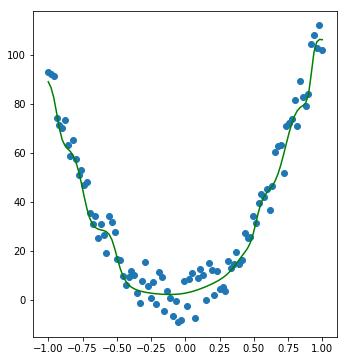

In [41]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=3000, verbose=300)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [42]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [43]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 53.17589104
epoch:  100/1000 loss_train: 16.56226753
epoch:  200/1000 loss_train: 8.68818449
epoch:  300/1000 loss_train: 5.54728995
epoch:  400/1000 loss_train: 4.70684204
epoch:  500/1000 loss_train: 4.32814553
epoch:  600/1000 loss_train: 3.92638130
epoch:  700/1000 loss_train: 2.18772884
epoch:  800/1000 loss_train: 2.04720443
epoch:  900/1000 loss_train: 3.21728683
epoch: 1000/1000 loss_train: 2.05405543


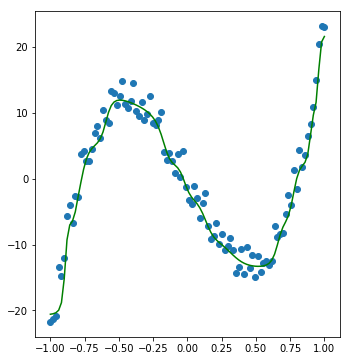

In [44]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [45]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [46]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 0.50500980
epoch:  100/1000 loss_train: 0.03771270
epoch:  200/1000 loss_train: 0.03131815
epoch:  300/1000 loss_train: 0.02694361
epoch:  400/1000 loss_train: 0.02444202
epoch:  500/1000 loss_train: 0.02274149
epoch:  600/1000 loss_train: 0.02142555
epoch:  700/1000 loss_train: 0.02038565
epoch:  800/1000 loss_train: 0.01957680
epoch:  900/1000 loss_train: 0.01895618
epoch: 1000/1000 loss_train: 0.01847998


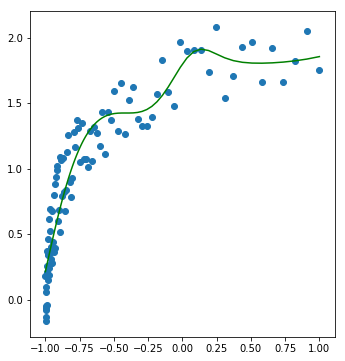

In [47]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [48]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [49]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 1072.77791958
epoch:  100/1000 loss_train: 43.79403516
epoch:  200/1000 loss_train: 25.76990003
epoch:  300/1000 loss_train: 21.49016350
epoch:  400/1000 loss_train: 18.94498622
epoch:  500/1000 loss_train: 17.96393079
epoch:  600/1000 loss_train: 17.88102034
epoch:  700/1000 loss_train: 17.85276818
epoch:  800/1000 loss_train: 17.82821052
epoch:  900/1000 loss_train: 17.80389428
epoch: 1000/1000 loss_train: 17.77990667


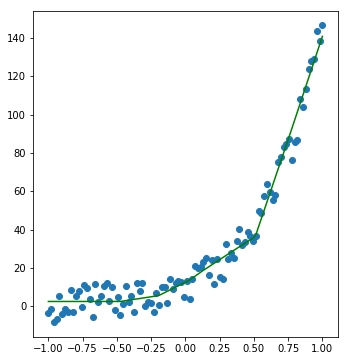

In [50]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [51]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1) # porta AND
# y = np.array([0, 1, 1, 1]).reshape(-1, 1) # porta OR

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/1000 loss_train: 0.67002839
epoch:  100/1000 loss_train: 0.14007197
epoch:  200/1000 loss_train: 0.08040569
epoch:  300/1000 loss_train: 0.05590983
epoch:  400/1000 loss_train: 0.04267605
epoch:  500/1000 loss_train: 0.03443262
epoch:  600/1000 loss_train: 0.02882170
epoch:  700/1000 loss_train: 0.02476353
epoch:  800/1000 loss_train: 0.02169567
epoch:  900/1000 loss_train: 0.01929705
epoch: 1000/1000 loss_train: 0.01737138
[[7.41931751 7.41931754]] [[-11.30157159]]
Predições:
[[1.23533418e-05]
 [2.01883619e-02]
 [2.01883614e-02]
 [9.71724138e-01]]
Acurácia: 100.00%


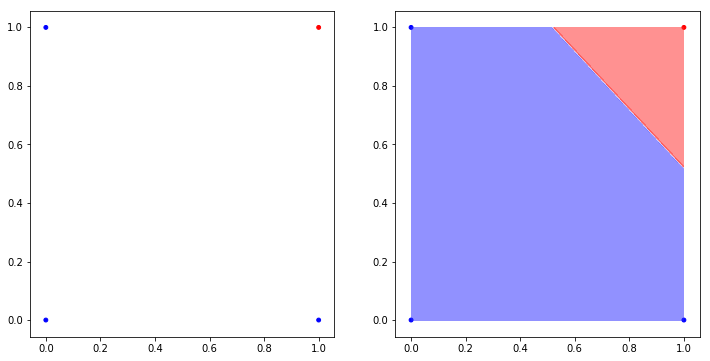

In [52]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights, nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

In [53]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/1000 loss_train: 0.69969509
epoch:  100/1000 loss_train: 0.69248558
epoch:  200/1000 loss_train: 0.68311289
epoch:  300/1000 loss_train: 0.58346582
epoch:  400/1000 loss_train: 0.43494220
epoch:  500/1000 loss_train: 0.38974759
epoch:  600/1000 loss_train: 0.37366660
epoch:  700/1000 loss_train: 0.36594089
epoch:  800/1000 loss_train: 0.36150578
epoch:  900/1000 loss_train: 0.35866019
epoch: 1000/1000 loss_train: 0.35669212
Predições:
[[0.01166474]
 [0.49565299]
 [0.98848366]
 [0.50419512]]
Acurácia: 50.00%


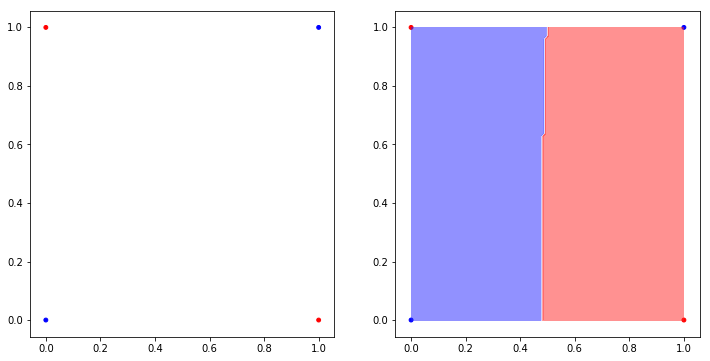

In [54]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

In [55]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 loss_train: 7.40700325
epoch: 1000/5000 loss_train: 0.00636577
epoch: 2000/5000 loss_train: 0.00427423
epoch: 3000/5000 loss_train: 0.00338954
epoch: 4000/5000 loss_train: 0.00286971
epoch: 5000/5000 loss_train: 0.00251678
Acurácia: 100.00%


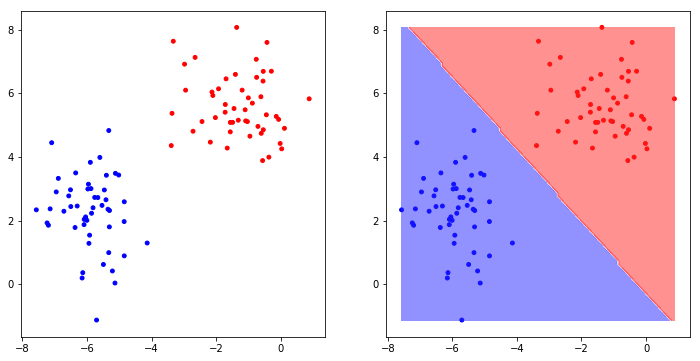

In [56]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)

print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= 0.5)))
plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 4 Clusters

In [57]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/500 loss_train: 1.13417933
epoch:  100/500 loss_train: 0.01873343
epoch:  200/500 loss_train: 0.00964765
epoch:  300/500 loss_train: 0.00663902
epoch:  400/500 loss_train: 0.00510766
epoch:  500/500 loss_train: 0.00417260
Acurácia: 100.00%


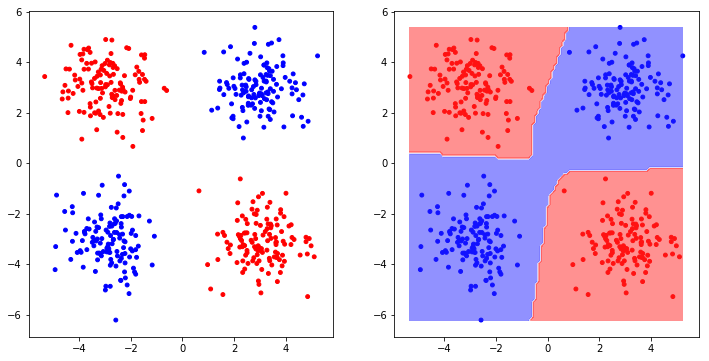

In [58]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=500, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

In [59]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/1000 loss_train: 1.91063624
epoch:  100/1000 loss_train: 0.10057624
epoch:  200/1000 loss_train: 0.05357874
epoch:  300/1000 loss_train: 0.03640860
epoch:  400/1000 loss_train: 0.02786062
epoch:  500/1000 loss_train: 0.02257595
epoch:  600/1000 loss_train: 0.01896259
epoch:  700/1000 loss_train: 0.01627208
epoch:  800/1000 loss_train: 0.01417167
epoch:  900/1000 loss_train: 0.01248511
epoch: 1000/1000 loss_train: 0.01109544
Acurácia: 100.00%


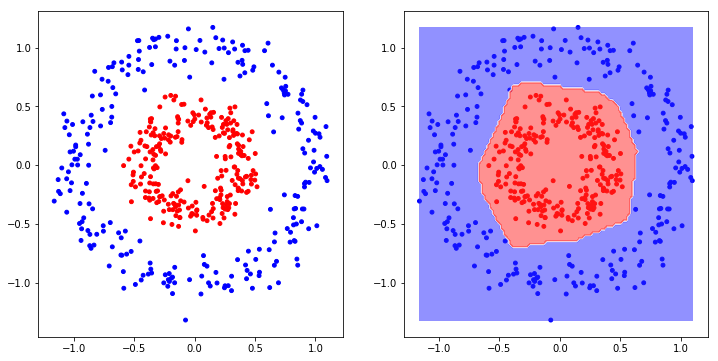

In [60]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

In [61]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/2000 loss_train: 0.88579520
epoch:  200/2000 loss_train: 0.26623885
epoch:  400/2000 loss_train: 0.22724787
epoch:  600/2000 loss_train: 0.19173665
epoch:  800/2000 loss_train: 0.16341158
epoch: 1000/2000 loss_train: 0.14254832
epoch: 1200/2000 loss_train: 0.12733242
epoch: 1400/2000 loss_train: 0.11603702
epoch: 1600/2000 loss_train: 0.10744392
epoch: 1800/2000 loss_train: 0.10074580
epoch: 2000/2000 loss_train: 0.09540674
Acurácia: 97.50%


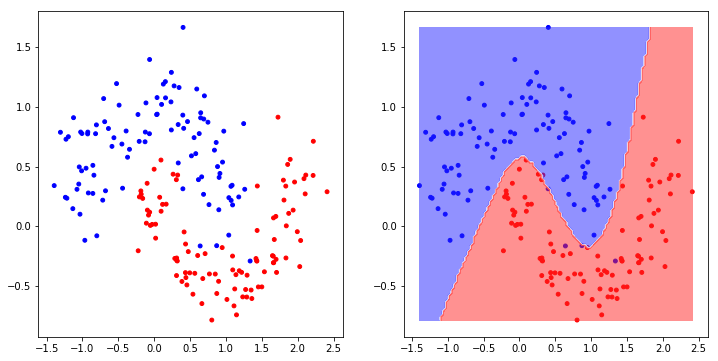

In [62]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=2000, verbose=200)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

In [63]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/5000 loss_train: 2.19349068
epoch:  500/5000 loss_train: 0.14113875
epoch: 1000/5000 loss_train: 0.07412121
epoch: 1500/5000 loss_train: 0.04928542
epoch: 2000/5000 loss_train: 0.03701253
epoch: 2500/5000 loss_train: 0.02989177
epoch: 3000/5000 loss_train: 0.02536678
epoch: 3500/5000 loss_train: 0.02224695
epoch: 4000/5000 loss_train: 0.01996947
epoch: 4500/5000 loss_train: 0.01823611
epoch: 5000/5000 loss_train: 0.01687380
Acurácia: 99.50%


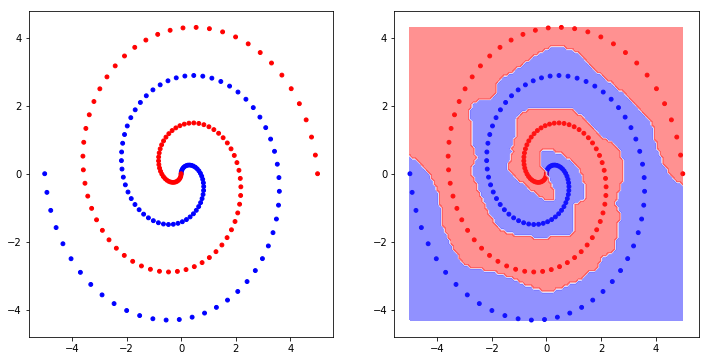

In [64]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=500)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters

In [65]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(300, 2) (300, 1)


In [66]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


/home/amp/tools/anaconda3/envs/ds-academy/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


epoch:    0/1000 loss_train: 0.33031653
epoch:  100/1000 loss_train: 0.01686049
epoch:  200/1000 loss_train: 0.00671087
epoch:  300/1000 loss_train: 0.00386111
epoch:  400/1000 loss_train: 0.00269893
epoch:  500/1000 loss_train: 0.00207961
epoch:  600/1000 loss_train: 0.00169446
epoch:  700/1000 loss_train: 0.00143165
epoch:  800/1000 loss_train: 0.00124067
epoch:  900/1000 loss_train: 0.00109536
epoch: 1000/1000 loss_train: 0.00098100
[[-0.38375821  0.75333118]
 [ 1.53011161  0.67962355]
 [ 1.06449551  1.77114376]
 [-1.30168811  0.35511046]
 [ 0.21034172  0.12172166]
 [ 0.42128009 -1.1150257 ]
 [ 0.40897982 -1.92269399]
 [-0.44528973  0.40060683]
 [ 0.6022881   1.63425737]
 [-0.63278585  0.85247542]]
[[-1.97732081 -0.6172012  -1.25189933  0.53664001  0.39745477  0.05143113
   1.13864228 -0.6691203   1.05384899 -0.93012633]
 [-0.23212026 -0.37988911 -0.11827402  0.84101339  0.10368313 -1.21046722
  -1.44712733 -0.36319729 -0.62416577  1.26139437]
 [ 1.5385284   1.26775868 -2.33194018 -

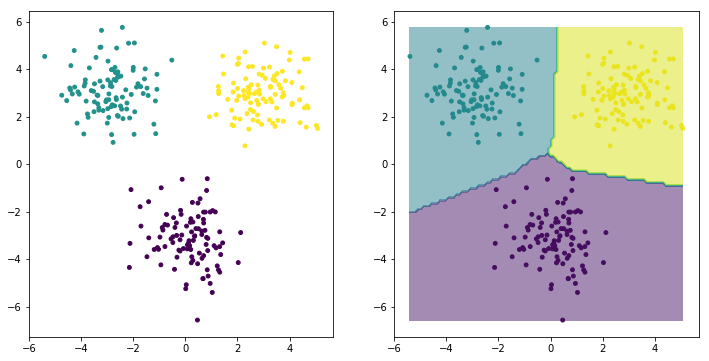

In [67]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

for layer in nn.layers:
    print(layer.weights)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### 4 Clusters

In [68]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(400, 2) (400, 1)


In [69]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


/home/amp/tools/anaconda3/envs/ds-academy/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


epoch:    0/1000 loss_train: 6.26448126
epoch:  100/1000 loss_train: 0.15064597
epoch:  200/1000 loss_train: 0.10792867
epoch:  300/1000 loss_train: 0.09541328
epoch:  400/1000 loss_train: 0.09018382
epoch:  500/1000 loss_train: 0.08707124
epoch:  600/1000 loss_train: 0.08485825
epoch:  700/1000 loss_train: 0.08312358
epoch:  800/1000 loss_train: 0.08163255
epoch:  900/1000 loss_train: 0.08036571
epoch: 1000/1000 loss_train: 0.07926698
Acurácia: 97.00%


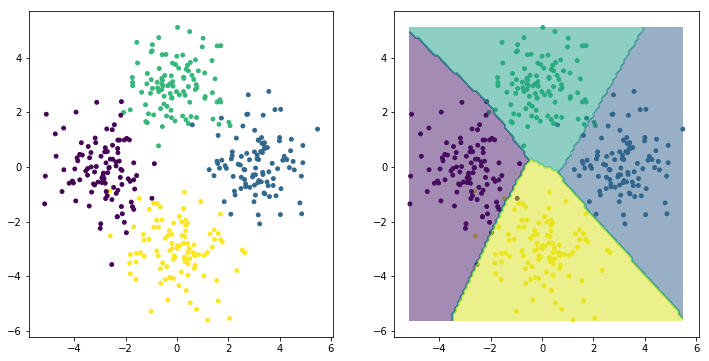

In [70]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Espiral - 5 classes

In [71]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


In [72]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


/home/amp/tools/anaconda3/envs/ds-academy/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


epoch:    0/2000 loss_train: 4.32335840
epoch:  200/2000 loss_train: 0.63380329
epoch:  400/2000 loss_train: 0.52707914
epoch:  600/2000 loss_train: 0.44739217
epoch:  800/2000 loss_train: 0.37285799
epoch: 1000/2000 loss_train: 0.31042900
epoch: 1200/2000 loss_train: 0.21804623
epoch: 1400/2000 loss_train: 0.16918404
epoch: 1600/2000 loss_train: 0.15202334
epoch: 1800/2000 loss_train: 0.12174571
epoch: 2000/2000 loss_train: 0.10225961
Acurácia: 97.60%


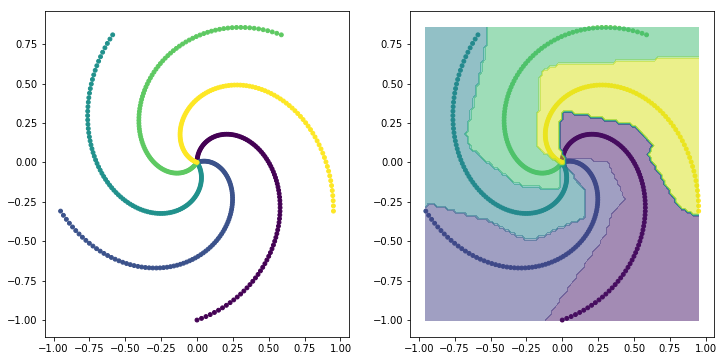

In [73]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [74]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


In [75]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


/home/amp/tools/anaconda3/envs/ds-academy/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


epoch:    0/1000 loss_train: 2.18417063
epoch:  100/1000 loss_train: 0.46427586
epoch:  200/1000 loss_train: 0.33374745
epoch:  300/1000 loss_train: 0.28689058
epoch:  400/1000 loss_train: 0.26441071
epoch:  500/1000 loss_train: 0.25224188
epoch:  600/1000 loss_train: 0.24432785
epoch:  700/1000 loss_train: 0.23858287
epoch:  800/1000 loss_train: 0.23437908
epoch:  900/1000 loss_train: 0.23108545
epoch: 1000/1000 loss_train: 0.22824632
Acurácia: 94.00%


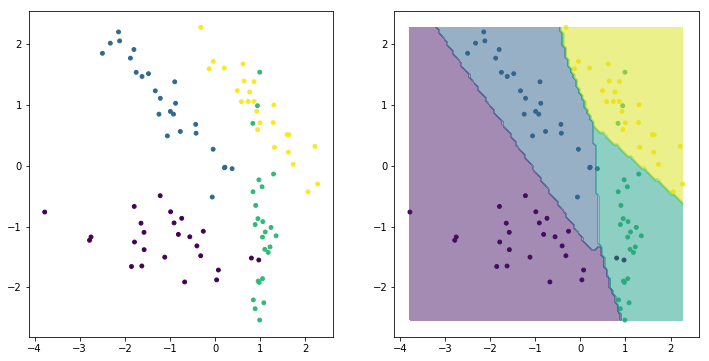

In [76]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [77]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [78]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/home/amp/tools/anaconda3/envs/ds-academy/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


epoch:    0/2000 loss_train: 1.70820031
epoch:  200/2000 loss_train: 0.49515205
epoch:  400/2000 loss_train: 0.35121061
epoch:  600/2000 loss_train: 0.27146586
epoch:  800/2000 loss_train: 0.22237948
epoch: 1000/2000 loss_train: 0.19554161
epoch: 1200/2000 loss_train: 0.17082655
epoch: 1400/2000 loss_train: 0.16668186
epoch: 1600/2000 loss_train: 0.14242319
epoch: 1800/2000 loss_train: 0.13598252
epoch: 2000/2000 loss_train: 0.13913921
Acurácia: 96.67%


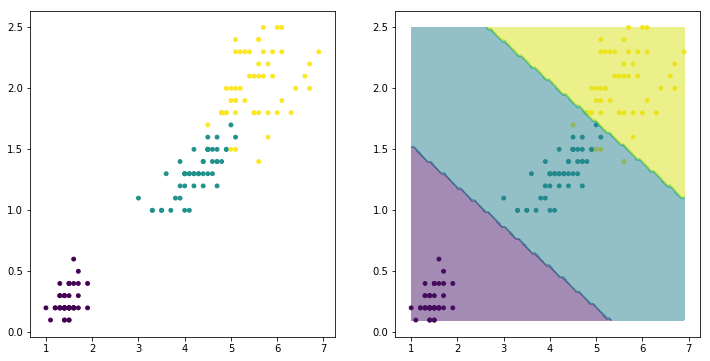

In [79]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

# 5. Referências 

- [Implementação completa de Redes Neurais com momentum, regularização, dropout, batch normalization, etc...](https://github.com/arnaldog12/Manual-Pratico-Deep-Learning/blob/master/Rede%20Neural.ipynb)